# Trabalho Final

## Utilizando agrupamento nebuloso para analisar relação das vulnerabilidades demográficas e socioeconômicas dos municípios brasileiros com os efeitos da Covid-19

### Preparação dos dados 

In [223]:
import pandas as pd
from sklearn import preprocessing
import skfuzzy.cluster as cluster
import numpy as np
import matplotlib.pyplot as plt
import os

#### Dados epidemiológicos

In [224]:
directory_covid = os.fsencode('dados/covid')
df_covid_geral = None
for file in os.listdir(directory_covid):
    filename = 'dados/covid/' + os.fsdecode(file)
    df_temp = pd.read_csv(filename, decimal=',', sep=';')
    if df_covid_geral is None:
        df_covid_geral = df_temp
    else:
        df_covid_geral = pd.concat([df_covid_geral, df_temp])

In [225]:
df_covid_municipios = df_covid_geral[df_covid_geral.municipio.isnull() == False].copy()
df_covid_municipios.codmun = df_covid_municipios.codmun.astype('Int64').astype('str')
df_covid_municipios.codRegiaoSaude = df_covid_municipios.codRegiaoSaude.astype('Int64').astype('str')
df_covid_municipios = \
    df_covid_municipios.astype({'coduf': str, 'semanaEpi': int,
                               'casosAcumulado': int, 'casosNovos': int, 'obitosAcumulado': int, 'obitosNovos': int})
df_covid_municipios.data = pd.to_datetime(df_covid_municipios.data, infer_datetime_format=True)

data_maxima = df_covid_municipios.data.max()
df_covid_municipios_mais_recente = df_covid_municipios[df_covid_municipios.data == data_maxima].copy()

df_covid_municipios_mais_recente = df_covid_municipios_mais_recente.rename(
    columns={'regiao': 'REGIAO', 'codmun': 'CODMUN6',
             'codRegiaoSaude': 'CODIGO_REGIAO_SAUDE', 'nomeRegiaoSaude': 'REGIAO_SAUDE', 'casosAcumulado': 'CASOS',
             'obitosAcumulado': 'OBITOS', 'interior/metropolitana': 'REGIAO_METROPOLITANA'})

#### Registros administrativos

In [226]:
df_registros_administrativos =  pd.read_csv('dados/registros_administrativos.csv', decimal=',', sep=';')
df_registros_administrativos = df_registros_administrativos.astype({'IBGE7': str})
df_registros_administrativos_2017 = df_registros_administrativos[df_registros_administrativos.ANO == 2017]
df_registros_administrativos_2016 = df_registros_administrativos[df_registros_administrativos.ANO == 2016]

#### Estimativa da população

In [227]:
df_estimativa_populacao =  pd.read_csv('dados/estimativa_populacao.csv', sep=';')
df_estimativa_populacao = df_estimativa_populacao.astype({'COD_UF': str, 'COD_MUNIC': str})
df_estimativa_populacao["CODMUN7"] = df_estimativa_populacao.COD_UF + df_estimativa_populacao.COD_MUNIC.str.zfill(5)

#### Atlas BR - Censo 2010

In [228]:
df_censo = pd.read_csv('dados/AtlasCenso/censo.csv', sep=';', decimal=',')
df_censo = df_censo[df_censo.ANO ==  2010]
df_censo = df_censo.rename(columns={'Codmun6': 'CODMUN6', 'Codmun7': 'CODMUN7', 'Município': 'NOMEMUN'})
df_censo = df_censo.astype({'CODMUN7': str, 'CODMUN6': str})
df_censo.columns = map(str.upper, df_censo.columns)
df_censo.UF = df_censo.UF.astype('Int64').astype('str')

#### IBGE - Censo 2010

##### Faixa etária

In [229]:
df_percentual_faixa_etaria = pd.read_csv('dados/IBGECenso/tab2_percentual_faixa_etaria.csv', sep=';', decimal=',')
df_percentual_faixa_etaria = df_percentual_faixa_etaria.dropna()
df_percentual_faixa_etaria.columns = df_percentual_faixa_etaria.columns.str.replace(" ", "_")
df_percentual_faixa_etaria.columns = df_percentual_faixa_etaria.columns.str.upper()
df_percentual_faixa_etaria.CODMUN7 = df_percentual_faixa_etaria.CODMUN7.astype('Int64').astype(str)

##### População sede municipal, área, densidade e domicílios

In [230]:
PATH_SINOPSE = 'dados/IBGECenso/SinopseEstados/'
directory_sinopse = os.fsencode(PATH_SINOPSE)
df_1_densidade = None
df_2_domicilios = None
for directory_state in os.listdir(directory_sinopse):
    directory_path = PATH_SINOPSE + '/' + os.fsdecode(directory_state)
    for file in os.listdir(directory_path):
        filename = os.fsdecode(file)

        if filename.startswith('tab2_1_'):
            relative_filename = directory_path + '/' + filename
            df_temp = pd.read_excel(relative_filename, header=None, usecols=[3, 7, 8, 9],
                                 skiprows=10, skipfooter=1)
            df_temp.columns = ['POPULACAO_SEDE_MUNICIPAL', 'AREA', 'DENSIDADE', 'CODMUN7']
            if df_1_densidade is None:
                df_1_densidade = df_temp
            else:
                df_1_densidade = pd.concat([df_1_densidade, df_temp])

        if filename.startswith('tab2_2_'):
            relative_filename = directory_path + '/' + filename
            df_temp = pd.read_excel(relative_filename, header=None, usecols=[2, 11],
                                 skiprows=10, skipfooter=2)
            df_temp.columns = ['TOTAL_DOMICILIOS_OCUPADOS', 'CODMUN7']
            if df_2_domicilios is None:
                df_2_domicilios = df_temp
            else:
                df_2_domicilios = pd.concat([df_2_domicilios, df_temp])
df_1_densidade.CODMUN7 = df_1_densidade.CODMUN7.astype('Int64').astype(str)
df_2_domicilios.CODMUN7 = df_2_domicilios.CODMUN7.astype('Int64').astype(str)

##### Aglomerados subnormais - Censo 2010

In [231]:
df_aglomerados_subnormais = pd.read_excel('dados/IBGECenso/aglomerados_subnormais.xls', header=None,
                                          usecols=[1, 2, 3, 4, 5, 6, 7], skiprows=8, skipfooter=3)
df_aglomerados_subnormais.columns = \
    ['NUMERO_AGLOMERADOS', 'NUMERO_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS',
     'POPULACAO_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS', 'AREA_AGLOMERADOS', 'DENSIDADE_DEMOGRAFICA_AGLOMERADOS',
     'DENSIDADE_DOMICILIOS_AGLOMERADOS','CODMUN7']
df_aglomerados_subnormais.CODMUN7 = df_aglomerados_subnormais.CODMUN7.astype('Int64').astype(str)
df_aglomerados_subnormais = df_aglomerados_subnormais[df_aglomerados_subnormais.CODMUN7.str.len() == 7]


#### Aglomerados subnormais - Estimativa 2019

In [232]:
df_aglomerados_subnormais_estimativa = pd.read_excel('dados/aglomerados_subnormais_estiamativa_2019.xls',
                                                     usecols=[1, 3, 4, 5, 8])
df_aglomerados_subnormais_estimativa = df_aglomerados_subnormais_estimativa.rename(columns={'CD_MUN': 'CODMUN7'})
df_aglomerados_subnormais_estimativa.columns = df_aglomerados_subnormais_estimativa.columns.str.upper()
df_aglomerados_subnormais_estimativa.CODMUN7 = df_aglomerados_subnormais_estimativa.CODMUN7.astype('Int64').astype(str)
df_aglomerados_subnormais_estimativa = df_aglomerados_subnormais_estimativa.fillna(0)

#### Eleições 2018

In [1]:
PATH_ELEICOES = 'dados/Eleicao2018/'
directory_eleicoes = os.fsencode(PATH_ELEICOES)
df_eleicoes = None
for directory_state in os.listdir(directory_eleicoes):
    directory_path = PATH_ELEICOES + '/' + os.fsdecode(directory_state)
    for file in os.listdir(directory_path):
        filename = os.fsdecode(file)

        if filename.endswith('.csv'):
            relative_filename = directory_path + '/' + filename
            df_eleicoes_temp = pd.read_csv(relative_filename, encoding='Latin 1', sep=';')
            df_eleicoes_temp = df_eleicoes_temp[df_eleicoes_temp.DS_CARGO_PERGUNTA == 'Presidente']
            df_eleicoes_temp = df_eleicoes_temp.groupby(['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NM_VOTAVEL']).sum()
            df_eleicoes_temp = df_eleicoes_temp[['QT_VOTOS']]
            df_eleicoes_branco = df_eleicoes_temp.loc[(slice(None), slice(None), 'Branco')]
            df_eleicoes_branco.columns = ['VOTOS_BRANCO']
            df_eleicoes_nulo = df_eleicoes_temp.loc[(slice(None), slice(None), 'Nulo')]
            df_eleicoes_nulo.columns = ['VOTOS_NULO']
            df_eleicoes_bolsonaro = df_eleicoes_temp.loc[(slice(None), slice(None), 'JAIR BOLSONARO')]
            df_eleicoes_bolsonaro.columns = ['VOTOS_BOLSONARO']
            df_eleicoes_haddad = df_eleicoes_temp.loc[(slice(None), slice(None), 'FERNANDO HADDAD')]
            df_eleicoes_haddad.columns = ['VOTOS_HADDAD']
            df_eleicoes_temp = pd.merge(df_eleicoes_bolsonaro, df_eleicoes_haddad, left_index=True, right_index=True)
            df_eleicoes_temp = pd.merge(df_eleicoes_temp, df_eleicoes_branco, left_index=True, right_index=True)
            df_eleicoes_temp = pd.merge(df_eleicoes_temp, df_eleicoes_nulo, left_index=True, right_index=True)
            df_eleicoes_temp = df_eleicoes_temp.reset_index(level=['CD_MUNICIPIO', 'NM_MUNICIPIO'])
            if df_eleicoes is None:
                df_eleicoes = df_eleicoes_temp
            else:
                df_eleicoes = pd.concat([df_eleicoes, df_eleicoes_temp])

df_eleicoes = df_eleicoes.rename(columns={'CD_MUNICIPIO': 'CODIGO_MUNICIPIO_TSE'})
df_codigos_tse_ibge = pd.read_csv('dados/municipios_brasileiros_tse.csv', usecols=[0, 3, 4])
df_codigos_tse_ibge.columns = ['CODIGO_MUNICIPIO_TSE', 'CAPITAL', 'CODMUN7']
df_eleicoes = pd.merge(df_eleicoes, df_codigos_tse_ibge, how="left", on=['CODIGO_MUNICIPIO_TSE'])
df_eleicoes.CODMUN7 = df_eleicoes.CODMUN7.astype('Int64').astype(str)

NameError: name 'os' is not defined

#### Preparação do datra frame principal

In [234]:
df_base = df_censo[['UF','CODMUN6','CODMUN7','NOMEMUN', 'IDHM','IDHM_E','IDHM_L','IDHM_R', 'FECTOT','CORTE1','CORTE2',
                    'CORTE3','CORTE4','CORTE9','GINI', 'PIND', 'PMPOB', 'PPOB', 'PREN10RICOS', 'PREN20','PREN20RICOS',
                    'PREN40','PREN60','PREN80', 'PRENTRAB','R1040','R2040', 'RDPC1','RDPC10','RDPC2','RDPC3','RDPC4',
                    'RDPC5','RDPCT','RIND','RMPOB','RPOB','THEIL', 'CPR','EMP','P_AGRO','P_COM','P_CONSTR','P_EXTR',
                    'P_FORMAL', 'P_SERV', 'P_TRANSF', 'REN0','REN1','REN2','REN3','REN5', 'T_ATIV', 'T_DES',
                    'THEILTRAB', 'TRABCC','TRABPUB','TRABSC', 'T_AGUA','T_BANAGUA', 'T_DENS', 'T_LUZ','AGUA_ESGOTO',
                    'T_OCUPDESLOC_1', 'HOMEMTOT', 'MULHERTOT', 'PEA', 'PESO1', 'PESO13', 'PESO4', 'PESO5', 'PESO610',
                    'PESO1114', 'PESO1517', 'PESO18', 'PESO65', 'PESORUR','PESOTOT','PESOURB', 'RAZDEP']]

##### Merge df_base and df_estimativa_populacao

In [235]:
df_estimativa_populacao_temp = df_estimativa_populacao[['CODMUN7', 'POPULACAO_ESTIMADA']]
df_base = pd.merge(df_estimativa_populacao_temp, df_base, how="left", on=['CODMUN7'])

##### Merge df_base and df_covid_municipios_mais_recente

In [236]:
df_covid_temp = df_covid_municipios_mais_recente[['REGIAO', 'CODMUN6', 'CODIGO_REGIAO_SAUDE', 'REGIAO_SAUDE', 'CASOS',
                                                  'OBITOS', 'REGIAO_METROPOLITANA']]

df_base = pd.merge(df_base, df_covid_temp, how="left", on=['CODMUN6'])
df_base.REGIAO_METROPOLITANA = df_base.REGIAO_METROPOLITANA.astype('Int64')
df_base.CASOS = df_base.CASOS.astype('Int64')
df_base.OBITOS = df_base.OBITOS.astype('Int64')

##### Merge df_base and df_registros_administrativos_2017

In [237]:
df_registros_administrativos_2017_temp = df_registros_administrativos_2017.rename(columns={'IBGE7': 'CODMUN7'})
df_registros_administrativos_2017_temp = df_registros_administrativos_2017_temp[
    ['CODMUN7','PINTERDRSAI', 'REN_RENSF_D', 'REN_TRPCBF_D', 'TXCOBPLP']]
df_base = pd.merge(df_base, df_registros_administrativos_2017_temp, how="left", on=['CODMUN7'])

df_registros_administrativos_2016_temp = df_registros_administrativos_2016.rename(columns={'IBGE7': 'CODMUN7'})
df_registros_administrativos_2016_temp = df_registros_administrativos_2016_temp[
    ['CODMUN7', 'REN_PVAADM', 'REN_PVAAGR', 'REN_PVAIND', 'REN_PVASERV']]
df_base = pd.merge(df_base, df_registros_administrativos_2016_temp, how="left", on=['CODMUN7'])

##### Merge df_base and df_percentual_faixa_etaria

In [238]:
df_percentual_faixa_etaria_temp = df_percentual_faixa_etaria[['CODMUN7', '0_A_5_ANOS', '6_A_14_ANOS', '15_A_24_ANOS',
                                                              '25_A_39_ANOS', '40_A_59_ANOS', '60_ANOS_OU_MAIS']]
df_base = pd.merge(df_base, df_percentual_faixa_etaria_temp, how="left", on=['CODMUN7'])

##### Merge df_base and df_1_densidade

In [239]:
df_base = pd.merge(df_base, df_1_densidade, how = 'left', on=['CODMUN7'])

##### Merge df_base and df_2_domicilios

In [240]:
df_base = pd.merge(df_base, df_2_domicilios, how = 'left', on=['CODMUN7'])

##### Merge df_base and df_aglomerados_subnomais

In [241]:
df_base = pd.merge(df_base, df_aglomerados_subnormais, how='left', on=['CODMUN7'])
df_base.NUMERO_AGLOMERADOS = df_base.NUMERO_AGLOMERADOS.fillna(0)
df_base.NUMERO_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS = df_base.NUMERO_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS.fillna(0)
df_base.POPULACAO_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS = df_base.POPULACAO_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS.fillna(0)
df_base.AREA_AGLOMERADOS = df_base.AREA_AGLOMERADOS.fillna(0)
df_base.DENSIDADE_DEMOGRAFICA_AGLOMERADOS = df_base.DENSIDADE_DEMOGRAFICA_AGLOMERADOS.fillna(0)
df_base.DENSIDADE_DOMICILIOS_AGLOMERADOS = df_base.DENSIDADE_DOMICILIOS_AGLOMERADOS.fillna(0)

##### Merge df_base and df_aglomerados_subnormais_estimativa

In [242]:
df_base = pd.merge(df_base, df_aglomerados_subnormais_estimativa, how='left', on=['CODMUN7'])

##### Merge df_base and df_eleicoes

In [243]:
df_base = pd.merge(df_base, df_eleicoes, how='left', on=['CODMUN7'])

#### Creating new attributes

In [244]:
df_base['TAXA_CASOS_100_MIL'] = df_base.CASOS / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_OBITOS_100_MIL'] = df_base.OBITOS / df_base.POPULACAO_ESTIMADA * 100000
df_base['TAXA_LETALIDADE'] = df_base.OBITOS / df_base.CASOS * 100
df_base['RAZAO_HOMEM_MULHER'] = df_base.HOMEMTOT / df_base.MULHERTOT
df_base['RAZAO_POPULACAO_RURAL_URBANA'] = df_base.PESORUR / df_base.PESOURB
df_base['PERCENTUAL_POPULACAO_SEDE_MUNICIPAL'] = df_base.POPULACAO_SEDE_MUNICIPAL / df_base.PESOTOT * 100
df_base['PERCENTUAL_POPULACAO_17_OU_MENOS_ANOS'] = \
    (df_base.PESO1 + df_base.PESO13 + df_base.PESO4 + df_base.PESO5 + df_base.PESO610 + df_base.PESO1114 + df_base.PESO1517) / df_base.PESOTOT * 100
df_base['PERCENTUAL_POPULACAO_18_ATE_39_ANOS'] = (df_base.PESO18 / df_base.PESOTOT * 100) - df_base['40_A_59_ANOS'] - df_base['60_ANOS_OU_MAIS']
df_base['PERCENTUAL_POPULACAO_40_ATE_59_ANOS'] = df_base['40_A_59_ANOS']
df_base['PERCENTUAL_POPULACAO_60_OU_MAIS_ANOS'] = df_base['60_ANOS_OU_MAIS']
df_base['DENSIDADE_DOMICILIOS'] = df_base.TOTAL_DOMICILIOS_OCUPADOS / df_base.AREA
df_base['PERCENTUAL_DOMICILIOS_AGLOMERADOS'] = df_base.NUMERO_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS / df_base.TOTAL_DOMICILIOS_OCUPADOS * 100
df_base['PERCENTUAL_POPULACAO_AGLOMERADOS'] = df_base.POPULACAO_DOMICILIOS_PARTICULARES_OCUPADOS_AGLOMERADOS / df_base.PESOTOT * 100
df_base['DENSIDADE_DOMICILIOS_ESTIMADA'] = df_base.EDOC_TOTAL / df_base.AREA
df_base['NUMERO_VOTOS'] = df_base.VOTOS_BOLSONARO + df_base.VOTOS_HADDAD + df_base.VOTOS_NULO + df_base.VOTOS_BRANCO
df_base['PERCENTUAL_VOTOS_BOLSONARO'] = df_base.VOTOS_BOLSONARO / df_base.NUMERO_VOTOS * 100
df_base['PERCENTUAL_VOTOS_HADDAD'] = df_base.VOTOS_HADDAD / df_base.NUMERO_VOTOS * 100

#### Analizing the attributes

In [245]:
df_base.head()

,CODMUN7,POPULACAO_ESTIMADA,UF,CODMUN6,NOMEMUN,IDHM,IDHM_E,IDHM_L,IDHM_R,FECTOT,...,PERCENTUAL_POPULACAO_18_ATE_39_ANOS,PERCENTUAL_POPULACAO_40_ATE_59_ANOS,PERCENTUAL_POPULACAO_60_OU_MAIS_ANOS,DENSIDADE_DOMICILIOS,PERCENTUAL_DOMICILIOS_AGLOMERADOS,PERCENTUAL_POPULACAO_AGLOMERADOS,DENSIDADE_DOMICILIOS_ESTIMADA,NUMERO_VOTOS,PERCENTUAL_VOTOS_BOLSONARO,PERCENTUAL_VOTOS_HADDAD
0,1100015,22728,11,110001,ALTA FLORESTA D'OESTE,0.641,0.526,0.763,0.657,2.24,...,36.751059,21.92,8.56,1.038059,0.0,0.0,1.076265,13082,65.158233,28.764715
1,1100023,109523,11,110002,ARIQUEMES,0.702,0.600,0.806,0.716,1.91,...,39.382769,20.31,6.74,6.153740,0.0,0.0,6.586581,48982,76.201462,18.092360
2,1100031,5188,11,110003,CABIXI,0.650,0.559,0.757,0.650,2.15,...,33.358543,24.81,10.23,1.505671,0.0,0.0,1.500345,3503,61.147588,31.687125
3,1100049,85893,11,110004,CACOAL,0.718,0.620,0.821,0.727,1.90,...,38.773744,21.92,8.24,6.392367,0.0,0.0,7.407183,48925,73.504343,20.625447
4,1100056,16204,11,110005,CEREJEIRAS,0.692,0.602,0.799,0.688,2.12,...,35.516240,22.68,9.87,1.927206,0.0,0.0,1.920380,9934,77.068653,17.565935


In [246]:
df_base.describe()

,POPULACAO_ESTIMADA,IDHM,IDHM_E,IDHM_L,IDHM_R,FECTOT,CORTE1,CORTE2,CORTE3,CORTE4,...,PERCENTUAL_POPULACAO_18_ATE_39_ANOS,PERCENTUAL_POPULACAO_40_ATE_59_ANOS,PERCENTUAL_POPULACAO_60_OU_MAIS_ANOS,DENSIDADE_DOMICILIOS,PERCENTUAL_DOMICILIOS_AGLOMERADOS,PERCENTUAL_POPULACAO_AGLOMERADOS,DENSIDADE_DOMICILIOS_ESTIMADA,NUMERO_VOTOS,PERCENTUAL_VOTOS_BOLSONARO,PERCENTUAL_VOTOS_HADDAD
count,5.570000e+03,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,...,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5.570000e+03,5570.000000,5570.000000
mean,3.801718e+04,0.659157,0.559094,0.801564,0.642873,2.190086,162.807687,268.376785,397.694329,626.775111,...,34.130785,22.317109,12.087829,32.904144,0.493634,0.515777,37.456378,2.077779e+04,42.377039,49.267973
std,2.228930e+05,0.071997,0.093328,0.044681,0.080662,0.503041,104.016954,141.599686,185.115673,279.801116,...,3.274896,3.977836,3.275977,176.412468,3.201667,3.276934,203.280660,1.260749e+05,20.030245,21.264359
min,7.760000e+02,0.418000,0.207000,0.672000,0.400000,1.210000,0.000000,0.000000,31.250000,150.000000,...,4.402798,9.040000,2.600000,0.022745,0.000000,0.000000,0.030865,6.800000e+02,1.964048,6.750630
25%,5.442250e+03,0.599000,0.490000,0.769000,0.572000,1.850000,72.860000,145.710000,236.000000,387.500000,...,32.374925,19.220000,9.910000,3.412583,0.000000,0.000000,3.625374,3.432000e+03,23.269031,31.139466
50%,1.166550e+04,0.665000,0.560000,0.808000,0.654000,2.130000,150.000000,253.670000,382.000000,575.000000,...,34.280998,22.460000,12.070000,7.313220,0.000000,0.000000,7.793902,6.530500e+03,44.783973,46.001979
75%,2.566375e+04,0.718000,0.631000,0.836000,0.707000,2.460000,241.750000,370.000000,510.000000,805.000000,...,36.102554,25.400000,14.160000,15.344681,0.000000,0.000000,16.691805,1.374425e+04,59.391523,68.784795
max,1.232523e+07,0.862000,0.825000,0.894000,0.891000,4.890000,585.000000,945.000000,1496.670000,2900.000000,...,49.975161,33.870000,29.380000,4188.891413,77.408529,77.017165,4440.743113,7.130554e+06,89.168766,95.838881


<AxesSubplot:>

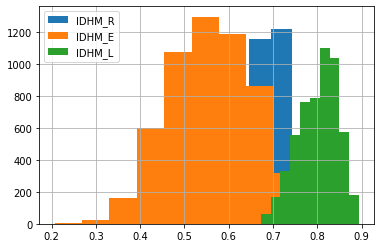

In [247]:
df_base.IDHM_R.hist(legend=True)
df_base.IDHM_E.hist(legend=True)
df_base.IDHM_L.hist(legend=True)

<AxesSubplot:>

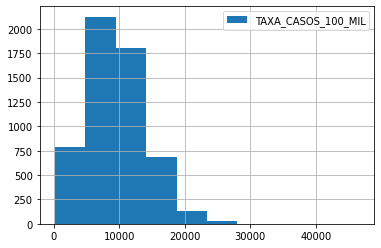

In [248]:
df_base.TAXA_CASOS_100_MIL.hist(legend=True)

<AxesSubplot:>

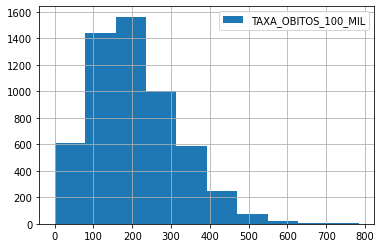

In [249]:
df_base.TAXA_OBITOS_100_MIL.hist(legend=True)

<AxesSubplot:>

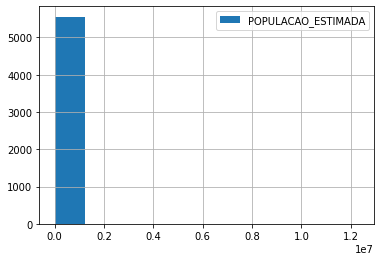

In [250]:
df_base.POPULACAO_ESTIMADA.hist(legend=True)

<AxesSubplot:xlabel='POPULACAO_ESTIMADA', ylabel='TAXA_LETALIDADE'>

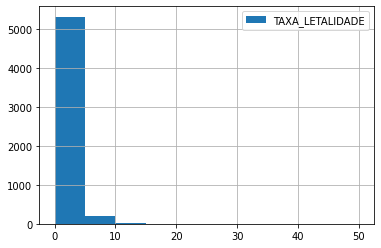

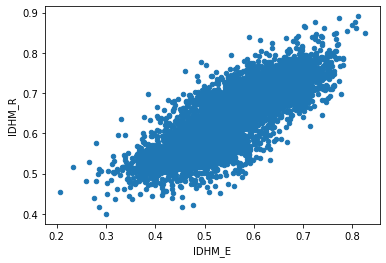

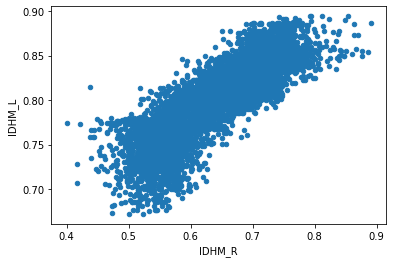

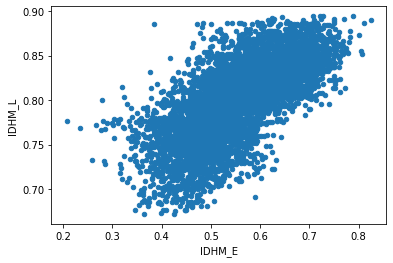

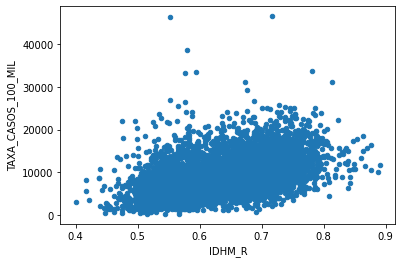

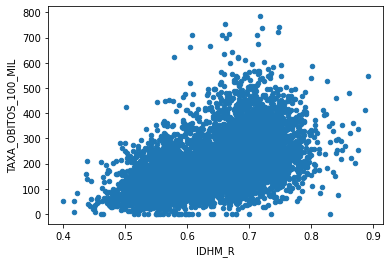

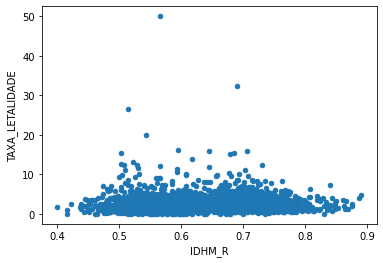

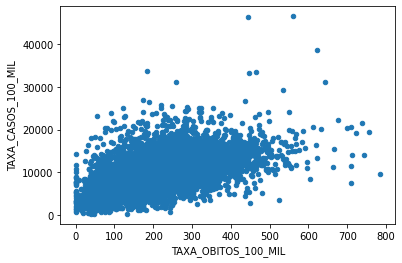

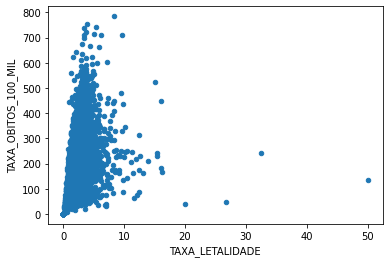

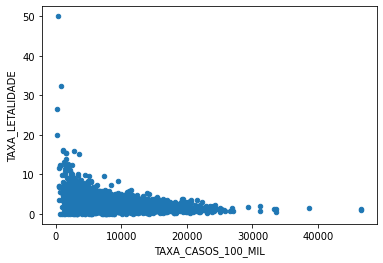

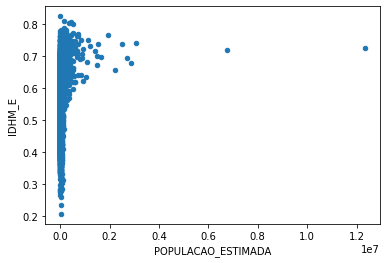

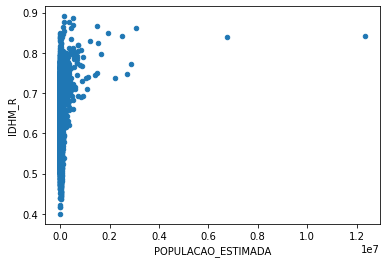

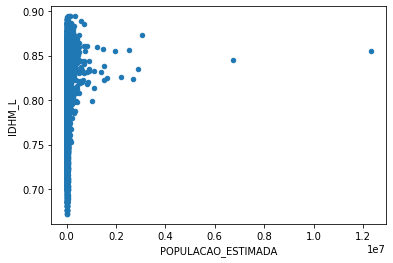

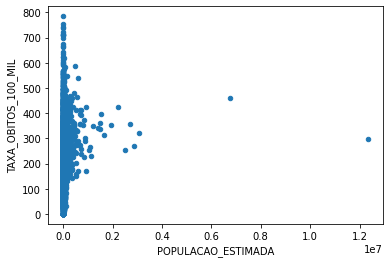

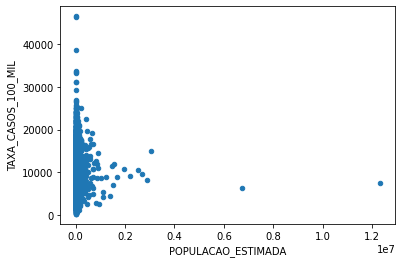

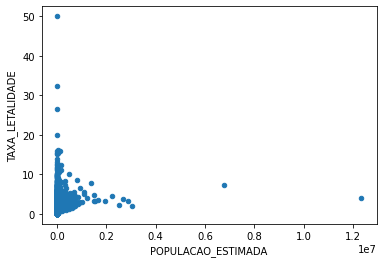

In [251]:
df_base.TAXA_LETALIDADE.hist(legend=True)
df_base.plot.scatter('IDHM_E', 'IDHM_R')
df_base.plot.scatter('IDHM_R', 'IDHM_L')
df_base.plot.scatter('IDHM_E', 'IDHM_L')
df_base.plot.scatter('IDHM_R', 'TAXA_CASOS_100_MIL')
df_base.plot.scatter('IDHM_R', 'TAXA_OBITOS_100_MIL')
df_base.plot.scatter('IDHM_R', 'TAXA_LETALIDADE')
df_base.plot.scatter('TAXA_OBITOS_100_MIL', 'TAXA_CASOS_100_MIL')
df_base.plot.scatter('TAXA_LETALIDADE', 'TAXA_OBITOS_100_MIL')
df_base.plot.scatter('TAXA_CASOS_100_MIL', 'TAXA_LETALIDADE')
df_base.plot.scatter('POPULACAO_ESTIMADA', 'IDHM_E')
df_base.plot.scatter('POPULACAO_ESTIMADA', 'IDHM_R')
df_base.plot.scatter('POPULACAO_ESTIMADA', 'IDHM_L')
df_base.plot.scatter('POPULACAO_ESTIMADA', 'TAXA_OBITOS_100_MIL')
df_base.plot.scatter('POPULACAO_ESTIMADA', 'TAXA_CASOS_100_MIL')
df_base.plot.scatter('POPULACAO_ESTIMADA', 'TAXA_LETALIDADE')

<AxesSubplot:>

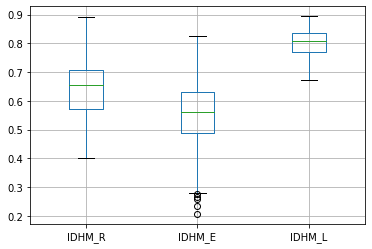

In [252]:
df_base.boxplot(column=["IDHM_R", "IDHM_E", "IDHM_L"])

<AxesSubplot:>

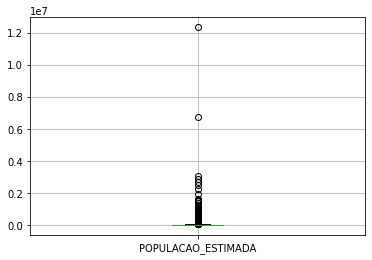

In [253]:
df_base.boxplot(column=["POPULACAO_ESTIMADA"])

<AxesSubplot:>

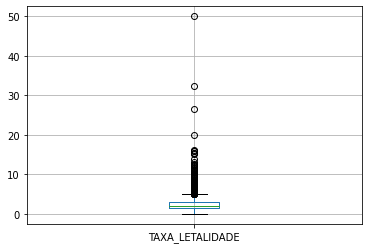

In [254]:
df_base.boxplot(column="TAXA_LETALIDADE")

<AxesSubplot:>

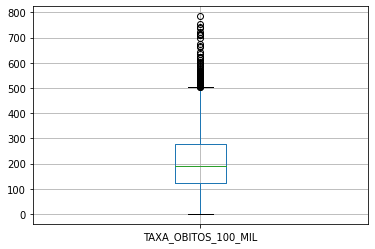

In [255]:
df_base.boxplot(column=["TAXA_OBITOS_100_MIL"])

<AxesSubplot:>

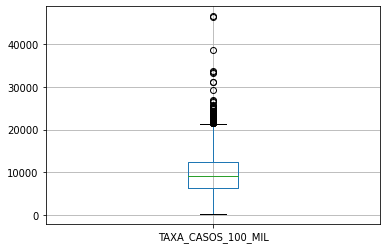

In [256]:
df_base.boxplot(column=["TAXA_CASOS_100_MIL"])

#### Removing outliers

In [257]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


#### Drop missing values, normalizing data, and selecting attributes

In [280]:
df_base = df_base.dropna()

df_antecedents_not_normalized = df_base[['POPULACAO_ESTIMADA', 'IDHM', 'IDHM_E', 'IDHM_L',
                                         'IDHM_R', 'PINTERDRSAI', 'REN_RENSF_D', 'REN_TRPCBF_D', 'REN_PVAADM',
                                         'REN_PVAAGR', 'REN_PVAIND', 'REN_PVASERV', 'TXCOBPLP', 'REGIAO_METROPOLITANA', 'FECTOT',
                                         'CORTE1','CORTE2', 'CORTE3','CORTE4','CORTE9','GINI', 'PIND', 'PMPOB', 'PPOB',
                                         'PREN10RICOS', 'PREN20','PREN20RICOS', 'PREN40','PREN60','PREN80', 'PRENTRAB',
                                         'R1040','R2040', 'RDPC1','RDPC10','RDPC2','RDPC3','RDPC4', 'RDPC5','RDPCT',
                                         'RIND','RMPOB','RPOB','THEIL', 'CPR','EMP','P_AGRO','P_COM','P_CONSTR','P_EXTR',
                    'P_FORMAL', 'P_SERV', 'P_TRANSF', 'REN0','REN1','REN2','REN3','REN5', 'T_ATIV', 'T_DES',
                    'THEILTRAB', 'TRABCC','TRABPUB','TRABSC', 'T_AGUA','T_BANAGUA', 'T_DENS', 'T_LUZ','AGUA_ESGOTO',
                    'T_OCUPDESLOC_1', 'PEA', 'RAZAO_HOMEM_MULHER',
                                         'RAZAO_POPULACAO_RURAL_URBANA', 'PERCENTUAL_POPULACAO_17_OU_MENOS_ANOS',
                                         'PERCENTUAL_POPULACAO_18_ATE_39_ANOS', 'PERCENTUAL_POPULACAO_40_ATE_59_ANOS',
                                         'PERCENTUAL_POPULACAO_60_OU_MAIS_ANOS', 'RAZDEP',
                                         'PERCENTUAL_POPULACAO_SEDE_MUNICIPAL', 'DENSIDADE', 'DENSIDADE_DOMICILIOS',
                                         'PERCENTUAL_DOMICILIOS_AGLOMERADOS', 'PERCENTUAL_POPULACAO_AGLOMERADOS',
                                         'DENSIDADE_DOMICILIOS_ESTIMADA', 'PER_AGSN', 'PERCENTUAL_VOTOS_BOLSONARO',
                                         'PERCENTUAL_VOTOS_HADDAD']]
scaler_antecedents = preprocessing.MinMaxScaler()
antecedents_normalized = scaler_antecedents.fit_transform(df_antecedents_not_normalized.values)
df_antecedents = pd.DataFrame(antecedents_normalized, columns=df_antecedents_not_normalized.columns)

df_consequents_not_normalized = df_base[['TAXA_CASOS_100_MIL', 'TAXA_OBITOS_100_MIL', 'TAXA_LETALIDADE']]
scaler_concequents = preprocessing.MinMaxScaler()
concequents_normalized = scaler_concequents.fit_transform(df_consequents_not_normalized.values)
df_concequents = pd.DataFrame(concequents_normalized, columns=df_consequents_not_normalized.columns)

<AxesSubplot:>

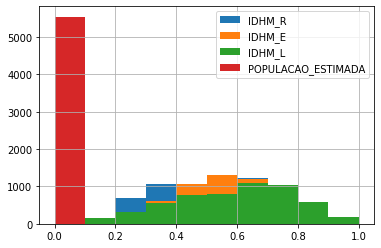

In [259]:
df_antecedents.IDHM_R.hist(legend=True)
df_antecedents.IDHM_E.hist(legend=True)
df_antecedents.IDHM_L.hist(legend=True)
df_antecedents.POPULACAO_ESTIMADA.hist(legend=True)

<AxesSubplot:>

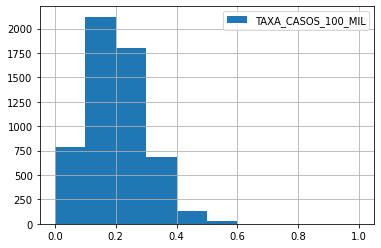

In [260]:
df_concequents.TAXA_CASOS_100_MIL.hist(legend=True)

<AxesSubplot:>

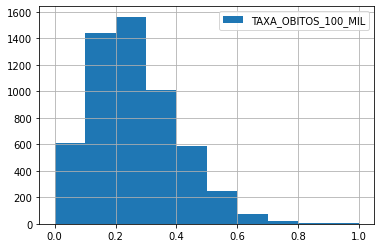

In [261]:
df_concequents.TAXA_OBITOS_100_MIL.hist(legend=True)

<AxesSubplot:>

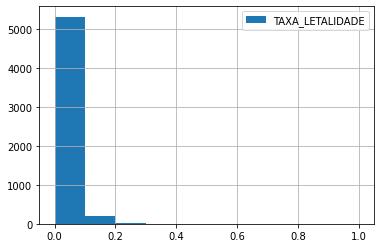

In [262]:
df_concequents.TAXA_LETALIDADE.hist(legend=True)

#### Executing fcmenas

In [263]:
from random import randrange


def plot_clusters(centers, u, x_not_normalized, y_not_normalized, df_not_normalized, scaler):
    cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization
    fig, ax = plt.subplots()

    for j in range(len(centers)):
        ax.plot(x_not_normalized.values[cluster_membership == j],
                y_not_normalized.values[cluster_membership == j], '.', label="Cluster " + str(j))
        ax.set_xlabel(x_not_normalized.name)
        ax.set_ylabel(y_not_normalized.name)
    ax.legend()

    centers_not_normalized = scaler.inverse_transform(centers)
    xi = df_not_normalized.columns.get_loc(x_not_normalized.name)
    yi = df_not_normalized.columns.get_loc(y_not_normalized.name)
    for pt in centers_not_normalized:
        ax.plot(pt[xi], pt[yi], 'rs')

    plt.show()


def describe_clusters(centers, u, df_not_normalized):
    cluster_membership = np.argmax(u, axis=0)
    for j in range(len(centers)):
        print("===================Cluster {0}==================".format(j))
        for column  in df_not_normalized.columns:
            print(df_not_normalized[cluster_membership == j][column].describe())
            print("\n")


def show_results(ra, centers, u, fpc, df_not_normalized, scaler, df_analysis):
    if ra is not None:
        print('RA = {0} - Subtractive Centers = {1}; FPC = {2:.2f}'.format(ra, len(centers), fpc))
    else:
        print('Centers = {0}; FPC = {1:.2f}'.format(len(centers), fpc))
    attributes = df_not_normalized.columns

    # for i in range(len(attributes) - 1):
    #     for j in range(i + 1, len(attributes)):
    #         plot_clusters(centers, u, df_not_normalized[attributes[i]], df_not_normalized[attributes[j]],
    #                       df_not_normalized, scaler)
    i = randrange(len(attributes))
    j = randrange(len(attributes))
    plot_clusters(centers, u, df_not_normalized[attributes[i]], df_not_normalized[attributes[j]], df_not_normalized,
                  scaler)

    print("Describing clusters")
    describe_clusters(centers, u, df_not_normalized)

    print("Describing results")
    describe_clusters(centers, u, df_analysis)

In [264]:
m = 2
epsilon = 10 ** (-4)


In [265]:
# ra_25=0.25
# centers_25, u_25, u0, d, jm, p, fpc_25 = cluster.cmeans(
#     df_antecedents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_25)

In [266]:
# centers_25_c, u_25_c, u0, d, jm, p, fpc_25_c = cluster.cmeans(
#     df_concequents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_25)

In [267]:
# show_results(ra_25, centers_25, u_25, fpc_25, df_antecedents_not_normalized, scaler_antecedents)
# show_results(ra_25, centers_25_c, u_25_c, fpc_25_c, df_consequents_not_normalized, scaler_concequents)

In [268]:
# ra_19=0.19
# centers_19, u_19, u0, d, jm, p, fpc_19 = cluster.cmeans(
#     df_antecedents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_19)

In [269]:
# centers_19_c, u_19_c, u0, d, jm, p, fpc_19_c = cluster.cmeans(
#     df_concequents.values.T, c=None, m=m, error=epsilon, maxiter=1000, init=None,
#     subtractive_clustering_influence_range=ra_19)

In [270]:
# show_results(ra_19, centers_19, u_19, fpc_19, df_antecedents_not_normalized, scaler_antecedents)
# show_results(ra_19, centers_19_c, u_19_c, fpc_19_c, df_consequents_not_normalized, scaler_concequents)
#

In [281]:
centers_2, u_2, u0, d, jm, p, fpc_2 = cluster.cmeans(
    df_antecedents.values.T, c=2, m=m, error=epsilon, maxiter=1000, init=None)

In [282]:
centers_2_c, u_2_c, u0, d, jm, p, fpc_2_c = cluster.cmeans(
    df_concequents.values.T, c=2, m=m, error=epsilon, maxiter=1000, init=None)

Centers = 2; FPC = 0.70


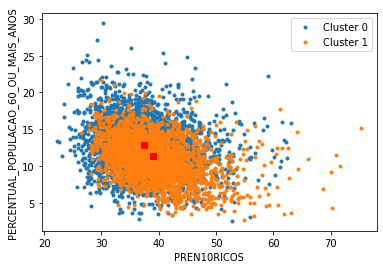

Describing clusters
===================Cluster 0==================
count    3.021000e+03
mean     5.481646e+04
std      3.011021e+05
min      7.760000e+02
25%      4.823000e+03
50%      1.128700e+04
75%      3.073300e+04
max      1.232523e+07
Name: POPULACAO_ESTIMADA, dtype: float64


count    3021.000000
mean        0.714283
std         0.038480
min         0.607000
25%         0.687000
50%         0.714000
75%         0.741000
max         0.862000
Name: IDHM, dtype: float64


count    3021.000000
mean        0.622292
std         0.063208
min         0.434000
25%         0.577000
50%         0.623000
75%         0.667000
max         0.825000
Name: IDHM_E, dtype: float64


count    3021.000000
mean        0.832961
std         0.024164
min         0.723000
25%         0.815000
50%         0.833000
75%         0.849000
max         0.894000
Name: IDHM_L, dtype: float64


count    3021.000000
mean        0.705244
std         0.042365
min         0.589000
25%         0.676000
50%         0.

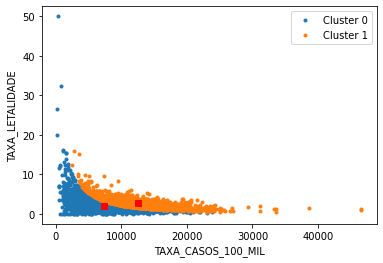

Describing clusters
===================Cluster 0==================
count     3295.000000
mean      7442.350992
std       3396.677759
min        178.954903
25%       5004.587151
50%       7140.639553
75%       9549.090719
max      23797.376093
Name: TAXA_CASOS_100_MIL, dtype: float64


count    3295.000000
mean      134.000791
std        55.738515
min         0.000000
25%        92.110719
50%       137.520055
75%       177.228156
max       255.754476
Name: TAXA_OBITOS_100_MIL, dtype: float64


count    3295.000000
mean        2.200257
std         1.870580
min         0.000000
25%         1.265823
50%         1.844844
75%         2.635254
max        50.000000
Name: TAXA_LETALIDADE, dtype: float64


===================Cluster 1==================
count     2263.000000
mean     12717.359506
std       4149.517636
min       2520.083839
25%      10071.609481
50%      12304.483837
75%      15069.654302
max      46603.917578
Name: TAXA_CASOS_100_MIL, dtype: float64


count    2263.000000
mean   

In [283]:
show_results(None, centers_2, u_2, fpc_2, df_antecedents_not_normalized, scaler_antecedents, df_consequents_not_normalized)
show_results(None, centers_2_c, u_2_c, fpc_2_c, df_consequents_not_normalized, scaler_concequents, df_antecedents_not_normalized)

In [274]:
centers_3, u_3, u0, d, jm, p, fpc_3 = cluster.cmeans(
    df_antecedents.values.T, c=3, m=m, error=epsilon, maxiter=1000, init=None)

In [275]:
centers_3_c, u_3_c, u0, d, jm, p, fpc_3_c = cluster.cmeans(
    df_concequents.values.T, c=3, m=m, error=epsilon, maxiter=1000, init=None)

Centers = 3; FPC = 0.48


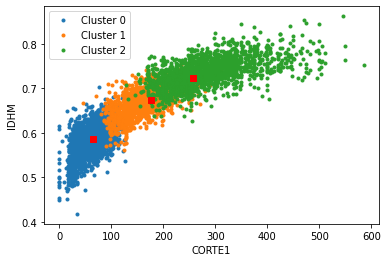

Describing clusters
===================Cluster 0==================
count      2068.000000
mean      17684.465184
std       16766.751980
min        1242.000000
25%        6657.500000
50%       12737.000000
75%       22063.000000
max      165525.000000
Name: POPULACAO_ESTIMADA, dtype: float64


count    2068.000000
mean        0.583040
std         0.035769
min         0.418000
25%         0.561000
50%         0.585000
75%         0.608000
max         0.704000
Name: IDHM, dtype: float64


count    2068.000000
mean        0.473510
std         0.060424
min         0.207000
25%         0.434000
50%         0.474000
75%         0.515000
max         0.667000
Name: IDHM_E, dtype: float64


count    2068.000000
mean        0.757018
std         0.030340
min         0.672000
25%         0.737000
50%         0.759000
75%         0.777000
max         0.847000
Name: IDHM_L, dtype: float64


count    2068.000000
mean        0.556122
std         0.036932
min         0.400000
25%         0.533000
50%   

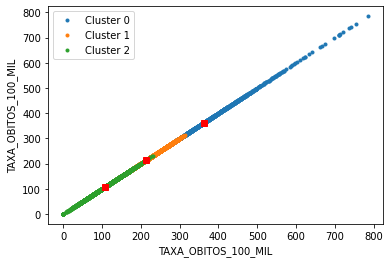

Describing clusters
===================Cluster 0==================
count     1243.000000
mean     13481.779946
std       4306.009435
min       2804.232804
25%      10800.316475
50%      13027.624564
75%      15859.816226
max      46603.917578
Name: TAXA_CASOS_100_MIL, dtype: float64


count    1243.000000
mean      367.900245
std        77.559136
min       183.598531
25%       314.629695
50%       347.912525
75%       406.907477
max       784.518828
Name: TAXA_OBITOS_100_MIL, dtype: float64


count    1243.000000
mean        3.016709
std         1.274790
min         0.545455
25%         2.224528
50%         2.842377
75%         3.500744
max        16.037736
Name: TAXA_LETALIDADE, dtype: float64


===================Cluster 1==================
count     2201.000000
mean     10792.790941
std       3571.170794
min        748.362956
25%       8307.926829
50%      10434.074246
75%      12754.158965
max      26956.521739
Name: TAXA_CASOS_100_MIL, dtype: float64


count    2201.000000
mean   

In [276]:
show_results(None, centers_3, u_3, fpc_3, df_antecedents_not_normalized, scaler_antecedents, df_consequents_not_normalized)
show_results(None, centers_3_c, u_3_c, fpc_3_c, df_consequents_not_normalized, scaler_concequents, df_antecedents_not_normalized)

In [277]:
centers_4, u_4, u0, d, jm, p, fpc_4 = cluster.cmeans(
    df_antecedents.values.T, c=4, m=m, error=epsilon, maxiter=1000, init=None)

In [278]:
centers_4_c, u_4_c, u0, d, jm, p, fpc_4_c = cluster.cmeans(
    df_concequents.values.T, c=4, m=m, error=epsilon, maxiter=1000, init=None)

Centers = 4; FPC = 0.36


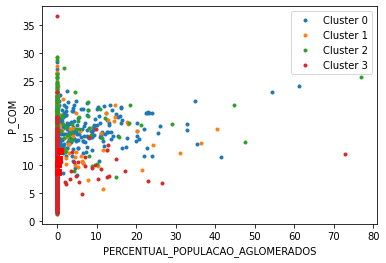

Describing clusters
===================Cluster 0==================
count    1.451000e+03
mean     9.659940e+04
std      4.293377e+05
min      8.380000e+02
25%      8.641000e+03
50%      2.204100e+04
75%      6.253900e+04
max      1.232523e+07
Name: POPULACAO_ESTIMADA, dtype: float64


count    1451.000000
mean        0.741084
std         0.029522
min         0.637000
25%         0.721000
50%         0.740000
75%         0.760000
max         0.862000
Name: IDHM, dtype: float64


count    1451.000000
mean        0.661888
std         0.049966
min         0.472000
25%         0.628000
50%         0.662000
75%         0.698000
max         0.825000
Name: IDHM_E, dtype: float64


count    1451.000000
mean        0.842752
std         0.021832
min         0.779000
25%         0.827000
50%         0.843000
75%         0.858000
max         0.894000
Name: IDHM_L, dtype: float64


count    1451.000000
mean        0.731149
std         0.035815
min         0.644000
25%         0.707000
50%         0.

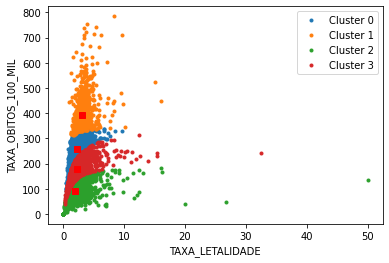

Describing clusters
===================Cluster 0==================
count     1485.000000
mean     12703.089844
std       3792.830634
min       3417.708000
25%      10165.975104
50%      12341.454781
75%      14869.680106
max      33659.730722
Name: TAXA_CASOS_100_MIL, dtype: float64


count    1485.000000
mean      256.309607
std        44.531686
min        91.107872
25%       225.225225
50%       261.276128
75%       291.290417
max       336.577484
Name: TAXA_OBITOS_100_MIL, dtype: float64


count    1485.000000
mean        2.268288
std         1.013737
min         0.382848
25%         1.595405
50%         2.083333
75%         2.710377
max         9.687500
Name: TAXA_LETALIDADE, dtype: float64


===================Cluster 1==================
count      815.000000
mean     13523.523911
std       4373.240423
min       2804.232804
25%      10871.991141
50%      13112.740079
75%      15825.516007
max      46603.917578
Name: TAXA_CASOS_100_MIL, dtype: float64


count    815.000000
mean    

In [279]:
show_results(None, centers_4, u_4, fpc_4, df_antecedents_not_normalized, scaler_antecedents, df_consequents_not_normalized)
show_results(None, centers_4_c, u_4_c, fpc_4_c, df_consequents_not_normalized, scaler_concequents, df_antecedents_not_normalized)